# 个性化推荐
本项目使用文本卷积神经网络，并使用[`MovieLens`](https://grouplens.org/datasets/movielens/)数据集完成电影推荐的任务。



推荐系统在日常的网络应用中无处不在，比如网上购物、网上买书、新闻app、社交网络、音乐网站、电影网站等等等等，有人的地方就有推荐。根据个人的喜好，相同喜好人群的习惯等信息进行个性化的内容推荐。比如打开新闻类的app，因为有了个性化的内容，每个人看到的新闻首页都是不一样的。

这当然是很有用的，在信息爆炸的今天，获取信息的途径和方式多种多样，人们花费时间最多的不再是去哪获取信息，而是要在众多的信息中寻找自己感兴趣的，这就是信息超载问题。为了解决这个问题，推荐系统应运而生。

协同过滤是推荐系统应用较广泛的技术，该方法搜集用户的历史记录、个人喜好等信息，计算与其他用户的相似度，利用相似用户的评价来预测目标用户对特定项目的喜好程度。优点是会给用户推荐未浏览过的项目，缺点呢，对于新用户来说，没有任何与商品的交互记录和个人喜好等信息，存在冷启动问题，导致模型无法找到相似的用户或商品。

为了解决冷启动的问题，通常的做法是对于刚注册的用户，要求用户先选择自己感兴趣的话题、群组、商品、性格、喜欢的音乐类型等信息，比如豆瓣FM：
<img src="assets/IMG_6242_300.PNG"/>

## 下载数据集
运行下面代码把[`数据集`](http://files.grouplens.org/datasets/movielens/ml-1m.zip)下载下来

In [274]:

import collections
from collections import Counter
import random
import math

import pandas as pd
import numpy as np
import scipy.sparse as ss

import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

from sklearn.externals.joblib import dump, load

In [275]:
data_dir = '../data/'
output_dir = '../output/'

In [276]:
def to_01(data):
    """归一化 pd.Series"""
    min_ = data.min()
    max_ = data.max()
    return (data - min_) / (max_ - min_)

def label_encoder(data):
    """LabelEncoder pd.Series"""
    return data.astype('category').values.codes

### 用户数据
分别有用户ID、性别、年龄、职业ID和邮编等字段。

数据中的格式：UserID::Gender::Age::Occupation::Zip-code

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



In [255]:
ufile_name = 'users.dat'
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table(data_dir+ufile_name, sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [256]:
# F:0, M:1
users['Gender'] = label_encoder(users['Gender']).astype(str)
# 0: 1: "Under 18"
# 1: 18: "18-24"
# 2: 25: "25-34"
# 3: 35: "35-44"
# 4: 45: "45-49"
# 5: 50: "50-55"
# 6: 56: "56+"
age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
users['Age'] = users['Age'].map(age_map).astype(str)
# 只限前5位, 并进行label_encoder
users['Zip-code'] = label_encoder(users['Zip-code'].apply(lambda x:x[:3])).astype(str)

users['OccupationID'] = users['OccupationID'].astype(str)

users[:5]

,UserID,Gender,Age,OccupationID,Zip-code
0,1,0,0,10,348
1,2,1,5,16,485
2,3,1,6,15,400
3,4,1,2,7,17
4,5,1,6,20,402


In [258]:
users = pd.get_dummies(users,)

In [259]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Columns: 709 entries, UserID to Zip-code_99
dtypes: int64(1), uint8(708)
memory usage: 4.1 MB


In [260]:
# 保存最终的 users
dump(users, output_dir+'users.joblib.gz', compress=('gzip',3))

['../output/users.joblib.gz']

### 电影数据
分别有电影ID、电影名和电影风格等字段。

数据中的格式：MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [213]:
movies_fname = 'movies.dat'
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table(data_dir+movies_fname, sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [214]:
genres = movies.pop('Genres')
for i in genres.index:
    for g in genres[i].split('|'):
        movies.loc[i,'Genres_{0}'.format(g)] = 1
movies.fillna(0,inplace=True)
movies.head()

,MovieID,Title,Genres_Animation,Genres_Children's,Genres_Comedy,Genres_Adventure,Genres_Fantasy,Genres_Romance,Genres_Drama,Genres_Action,Genres_Crime,Genres_Thriller,Genres_Horror,Genres_Sci-Fi,Genres_Documentary,Genres_War,Genres_Musical,Genres_Mystery,Genres_Film-Noir,Genres_Western
0,1,Toy Story (1995),1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
title = movies.pop('Title')
movies['Title_name'] = title.apply(lambda x: x[:-7])
#movies['Title_name'] = movies['Title_name'].apply(lambda x:str(hash(x))[-9:])
movies['Title_yeay'] = to_01(title.apply(lambda x: x[-5:-1]).astype(np.float64))
#movies['Title_yeay'] = title.apply(lambda x: x[-5:-1])
#movies['Genres'] = movies['Genres'].apply(lambda x:str(hash(x))[-9:])
movies[:5]

,MovieID,Genres_Animation,Genres_Children's,Genres_Comedy,Genres_Adventure,Genres_Fantasy,Genres_Romance,Genres_Drama,Genres_Action,Genres_Crime,...,Genres_Horror,Genres_Sci-Fi,Genres_Documentary,Genres_War,Genres_Musical,Genres_Mystery,Genres_Film-Noir,Genres_Western,Title_name,Title_yeay
0,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Toy Story,0.938272
1,2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Jumanji,0.938272
2,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Grumpier Old Men,0.938272
3,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Waiting to Exhale,0.938272
4,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Father of the Bride Part II,0.938272


In [216]:
# 把字符串中的标点符号 转为' '
punctuation = set(['(',')',',',':','-','.',"'"])
title_name = movies.pop('Title_name').apply(lambda x:''.join(list(map(lambda x:''if x in punctuation else x, x))))
# 以空格分割 title
title_name = title_name.apply(lambda x:x.lower().split(' '))#.values
title_name[:5]

0                          [toy, story]
1                             [jumanji]
2                  [grumpier, old, men]
3                 [waiting, to, exhale]
4    [father, of, the, bride, part, ii]
Name: Title_name, dtype: object

In [217]:
# 2D -> 1D
vs = []
for v in title_name:
    vs.extend(v)
# 转为全小写
vocabulary = pd.Series(vs)#.apply(str.lower)
vocabulary.value_counts()[:10]

the     1251
of       364
a        170
in       148
and      148
to        84
man       71
on        63
love      56
ii        51
dtype: int64

In [218]:
# 把停用词替换为'_stopword_'
stopwords = set(['the', 'of', 'a', 'in', 'to', 'on', 'for', '&', 'and',
                 'is', 'an', 'about', 'that', 'at', 'by', 'or','off',
                 'this', 'with', 'upon', 'who'])
vocabulary = vocabulary.apply(lambda w:'_stopword_' if w in stopwords else w)
vocabulary.value_counts()[:10]

_stopword_    2487
man             71
love            56
ii              51
my              47
i               47
la              44
2               43
from            37
night           36
dtype: int64

In [219]:
data_size = len(vocabulary)
totle_words = len(set(vocabulary))
print('data_size is', data_size)
print('totle_words is', totle_words)

data_size is 11793
totle_words is 4566


In [107]:
# 建立数据集, words是所有单词列表, n_words是想建的字典中的单词的个数
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]  #将所有低频词设为'UNK', 个数为-1
    count.extend(collections.Counter(words).most_common(n_words - 1))
    #将words集合中的单词按频数排序，将频率最高的前
    #n_words-1个单词以及他们的出现的个数按顺序输出到count中，
    #将频数排在n_words-1之后的单词设为UNK。
    #同时，count的规律为索引越小，单词出现的频率越高
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    #对count中所有单词进行编号，由0开始，保存在字典dict中

    data = list()
    unk_count = 0
    #对原words列表中的单词使用字典中的ID进行编号，
    #即将单词转换成整数，储存在data列表中
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1 # 对UNK进行计数
        data.append(index)
    count[0][1] = unk_count #'UNK'个数
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    #将dictionary中的数据反转，即可以通过ID找到对应的单词
    return data, count, dictionary, reversed_dictionary

In [108]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 4000

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)

print('Most common words (+UNK)', count[:5]) 
# 输出频数最高的前5个单词
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])


Most common words (+UNK) [['UNK', 567], ('_stopword_', 2487), ('man', 71), ('love', 56), ('ii', 51)]
Sample data [815, 13, 2834, 1947, 163, 35, 276, 1, 1809, 374] ['toy', 'story', 'jumanji', 'grumpier', 'old', 'men', 'waiting', '_stopword_', 'exhale', 'father']


In [109]:

data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
# 生成batch, 对data中的单词,分别与其前一个和后一个单词生成batch
# batch内容为: [data[1], data[0]]
def generate_batch(batch_size, num_skips, skip_window):
    global data_index  # 全局索引
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  #窗的大小为3，结构为 [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    #建立一个结构为双向队列的缓冲区，大小不超过3
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    #将数据index到index+3的字段赋值给buffer，大小刚好为span
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window] # 生成batch
            labels[i * num_skips + j, 0] = buffer[context_word]  # 生成对应labels
        if data_index == len(data): #是否遍历完data
            buffer = data[:span]
            data_index = span
            # 重新开始, 将data前span位传入buffer, 重置data_index
        else:
            buffer.append(data[data_index])
            data_index += 1
            # 没有遍历结束, 在buffer尾部加入一个单词并挤出buffer中最前单词
            # 相当于span后移一位
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    # 重置data_index, 为避免身后移动apan时超出data
    return batch, labels


In [110]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

13 story -> 815 toy
13 story -> 2834 jumanji
2834 jumanji -> 13 story
2834 jumanji -> 1947 grumpier
1947 grumpier -> 163 old
1947 grumpier -> 2834 jumanji
163 old -> 1947 grumpier
163 old -> 35 men


In [125]:
# Step 4: Build and train a skip-gram model.

batch_size = 128 # 128
embedding_size = 64  # Dimension of the embedding vector.
skip_window = 2       # How many words to consider left and right.
num_skips = 4         # How many times to reuse an input to generate a label.
num_sampled = 32      # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 64  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)


In [126]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    # 输入一个batch的训练数据，是当前单词在字典中的索引id
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    # 输入一个batch的训练数据的标签，是当前单词前一个或者后一个单词在字典中的索引id
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    #从字典前100个单词，即频率最高的前100个单词中，随机选出16个单词，将它们的id储存起来，作为验证集
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
    #with tf.variable_scope("word2vec"):
        # Look up embeddings for inputs.
        # 初始化字典中每个单词的embeddings，值为-1到1的均匀分布
        embeddings = tf.Variable( 
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) #5000*128
        #找到训练数据对应的embeddings
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        #初始化训练参数
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        # 初始化偏置

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

    '''
    算法非常简单，根据词频或者类似词频的概率选出64个负采样v，联同正确的输入w（都是词的id），用它们在nce_weights对应的向量组成一个训练子集mu。
    对于训练子集中各个元素mu(i)，如果是w或者m(i)==w(w这里是输入对应的embedding)，loss(i)=log(sigmoid(w*mu(i)))
    如果是负采样，则loss(i)=log(1-sigmoid(w*mu(i)))
    然后将所有loss加起来作为总的loss，loss越小越相似（余弦定理）
    用总的loss对各个参数求导数，来更新nce_weight以及输入的embedding
    '''

    loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    #对embedding进行归一化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm   #要保存的embedding
    #找到验证集中的id对应的embedding
    valid_embeddings = tf.nn.embedding_lookup(
                        normalized_embeddings, valid_dataset)
    #判断验证集和整个归一化的embedding的相似性
    similarity = tf.matmul(
                        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()


In [127]:
# Step 5: Begin training.
num_steps = 100000

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
                batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:  #求移动平均loss
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:  #评估一下验证集和整个embeddings的相似性
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  111.751251221
Nearest to blood: murphys, stah, mir, normal, metropolitan, van, ans, cobb,
Nearest to house: crash, better, diary, pimp, abbotts, inspector, near, theory,
Nearest to aka: battlefield, smell, business, shane, formidable, florette, candleshoe, spaceballs,
Nearest to 2: prom, braindead, quilt, garbage, shao, f/x, young, myself,
Nearest to boys: knowledge, prick, survival, kane, charm, loves, fe, plan�te,
Nearest to one: superman, clockers, onna, outside, diamonds, thin, brother, pig,
Nearest to movie: met, bedknobs, vicious, did, onna, indiana, hsing, farewell,
Nearest to de: backdraft, it, hour, firewalker, stigmata, police, outfield, stalingrad,
Nearest to star: dellesorcismo, 301, raging, torn, few, cocoon, saucer, damsel,
Nearest to le: dundee, gold, salvation, saludos, dictator, dansu?, swing, detroit,
Nearest to men: defying, brujo, goodfellas, dolittle, menace, shield, plunkett, hairy,
Nearest to lost: masters, diabolique, attac

In [118]:

# 保存dictionary和reverse_dictionary
dump(reverse_dictionary, output_dir+'reverse_dictionary.joblib.gz', compress=('gzip',3))
dump(dictionary, output_dir+'dictionary.joblib.gz', compress=('gzip',3))
# 保存最终的 word embedding
dump(final_embeddings, output_dir+'final_embeddings.joblib.gz', compress=('gzip',3))

['../output/final_embeddings.joblib.gz']

In [119]:
# Step 6: Visualize the embeddings.
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    # 指定默认字体为黑体
    #plt.rcParams['font.sans-serif'] = ['SimHei'] 
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig(filename)
    plt.show()

/home/zhou/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


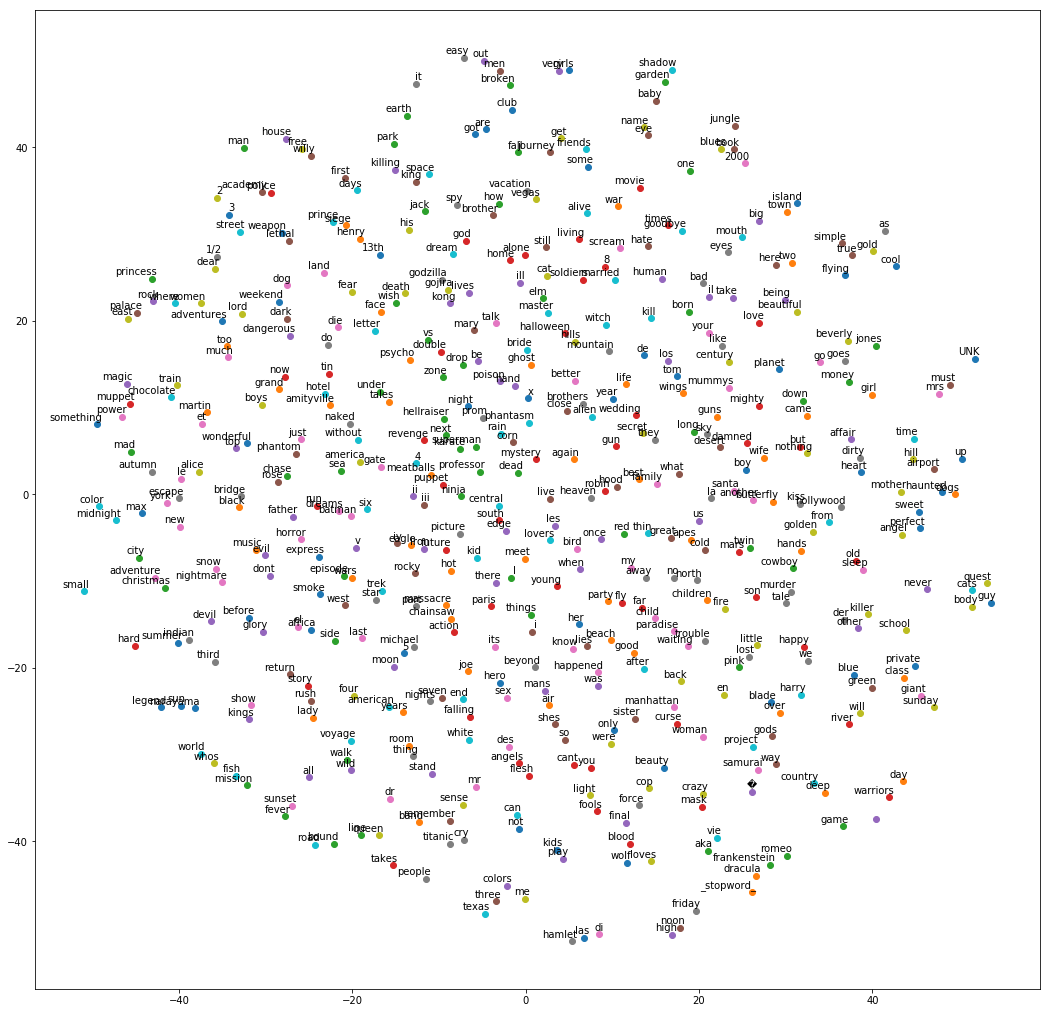

In [130]:
try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in range(plot_only)]
    plot_with_labels(low_dim_embs, labels, output_dir+'tsne.png')

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

In [220]:
title_name_vec = title_name.copy()
n = 6
n_len = n*64
for ts_i in title_name.index:
    #print(ts_i,'=============')
    w2vs = []
    for i,t in enumerate(title_name[ts_i]):
        if t in stopwords: t = '_stopword_'
        #print(t)
        try: v = final_embeddings[dictionary[t]]
        except KeyError: v = np.zeros((64))
        w2vs.extend(v)
        if i >= n-1: break
    if len(w2vs) < n_len:
        w2vs.extend(np.zeros((n_len - len(w2vs))))
    title_name_vec[ts_i] = np.array(w2vs)
    #print(w2vs)
title_name_vec[:5]

0    [-0.100306324661, -0.125954583287, 0.252385467...
1    [0.0723816901445, -0.219793900847, 0.218488648...
2    [0.0416548736393, -0.180154129863, 0.022101227...
3    [-0.0143924588338, -0.221631288528, 0.06839706...
4    [-0.0654749, -0.268731, 0.116162, 0.0978634, 0...
Name: Title_name, dtype: object

In [232]:
for i in range(n_len):
    movies['Sent_vec_{0}'.format(i)] = 0.0
for i in movies.index:
    if i%100 == 0: print(i)
    movies.iloc[i,-n_len:] = title_name_vec[i]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800


In [261]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Columns: 404 entries, MovieID to Sent_vec_383
dtypes: float64(403), int64(1)
memory usage: 12.0 MB


In [238]:
# 保存最终的 movies
dump(movies, output_dir+'movies.joblib.gz', compress=('gzip',3))

['../output/movies.joblib.gz']

MovieID是类别字段，Title是文本，Genres也是类别字段

### 评分数据
分别有用户ID、电影ID、评分和时间戳等字段。

数据中的格式：UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [279]:
ratings_fname = 'ratings.dat'
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table(data_dir+ratings_fname, sep='::', header=None, names=ratings_title, engine = 'python')
ratings.drop(columns='timestamps', inplace=True)
ratings['Rating'] = ratings['Rating']/5.0
ratings.head()

,UserID,MovieID,Rating
0,1,1193,1.0
1,1,661,0.6
2,1,914,0.6
3,1,3408,0.8
4,1,2355,1.0


In [280]:
ratings['UserID'].max(), ratings['MovieID'].max()

(6040, 3952)

评分字段Rating就是我们要学习的targets，时间戳字段我们不使用。

In [281]:
# 生成全是0的稀疏矩阵
user_movie_rating = ss.lil_matrix((ratings['UserID'].max()+1, ratings['MovieID'].max()+1), dtype=np.float32)
# 把打分数据填入稀疏矩阵
for i in ratings.index:
    u_id = ratings.loc[i,'UserID']
    m_id = ratings.loc[i,'MovieID']
    user_movie_rating[u_id,m_id] = ratings.loc[i,'Rating']


In [282]:
# 保存最终的 movies
dump(user_movie_rating, output_dir+'user_movie_rating.joblib.gz', compress=('gzip',3))

['../output/user_movie_rating.joblib.gz']